# Figures S18

This notebook loads the data and produces figure S18. 

In [1]:
savedate = '20251031'

In [2]:
data_folder = '' # path to data

In [3]:
import pandas as pd
import geopandas as geopd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import numpy as np
import us
import state_name_crs_mappings_ML as crsm
pd.options.mode.chained_assignment = None 
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

## Load and process data

In [4]:
# Load data
df_bg_level = pd.read_csv(data_folder + '21c_level_BG_US_compiled_wlabels_250530.zip',dtype={'GEOID':str,'STATEFP':str,'COUNTYFP':str,'BGFIPS':str},index_col=0)
df_bg_level['STATEFP'] = df_bg_level['STATEFP'].str.zfill(2)
df_bg_level['COUNTYFP'] = df_bg_level['COUNTYFP'].str.zfill(5)

# Load map
gdf_county = geopd.read_file('/Volumes/mtec_nas_sustec_energydb/Siobhan/Private_Data/SafeGraphData/ProcessedData/geodata/tl_2022_us_county/tl_2022_us_county.shp')
crs = int(crsm.state_to_crs(crsm.abbrev_to_state('MS')).split(':')[1]) #crs = 2163
gdf_county = gdf_county.to_crs(epsg=crs)

full_state_list = [state.abbr for state in us.states.STATES]
state_list_lower48 = [k for k in full_state_list if k not in ['HI', 'AK']]
fips_all = [us.states.lookup(state).fips for state in state_list_lower48]

# IRA data by county
df_bg_level['IRA_pop'] = df_bg_level['share_IRA'].values * df_bg_level['total_pop_byBG'].values
tmp1 = df_bg_level.groupby(['COUNTYFP'])[['IRA_pop', 'total_pop_byBG', 'no_stations']].sum()
tmp2 = df_bg_level.groupby(['COUNTYFP'])['income_quantile_county_US'].mean()
tmp3 = tmp1.merge(tmp2, on='COUNTYFP')

# Merge
gdf_county['COUNTYFP5'] = gdf_county['STATEFP'].astype(str) + gdf_county['COUNTYFP'].astype(str)
gdf_county = pd.merge(gdf_county, tmp3.reset_index(names=['COUNTYFP5']), on='COUNTYFP5')
gdf_county = gdf_county.loc[~(gdf_county['STATEFP'].isin(['02', '15']))]

# Bins to plot
gdf_county['share_IRA'] = gdf_county['IRA_pop'].values / gdf_county['total_pop_byBG'].values
gdf_county['share_IRA_binned'] = 0
gdf_county.loc[gdf_county.loc[(gdf_county['share_IRA']>=0)&((gdf_county['share_IRA']<0.2))].index, 'share_IRA_binned'] = 1
gdf_county.loc[gdf_county.loc[(gdf_county['share_IRA']>=0.2)&((gdf_county['share_IRA']<0.4))].index, 'share_IRA_binned'] = 2
gdf_county.loc[gdf_county.loc[(gdf_county['share_IRA']>=0.4)&((gdf_county['share_IRA']<0.6))].index, 'share_IRA_binned'] = 3
gdf_county.loc[gdf_county.loc[(gdf_county['share_IRA']>=0.6)&((gdf_county['share_IRA']<0.8))].index, 'share_IRA_binned'] = 4
gdf_county.loc[gdf_county.loc[(gdf_county['share_IRA']>=0.8)&((gdf_county['share_IRA']<=1.0))].index, 'share_IRA_binned'] = 5

# Plot

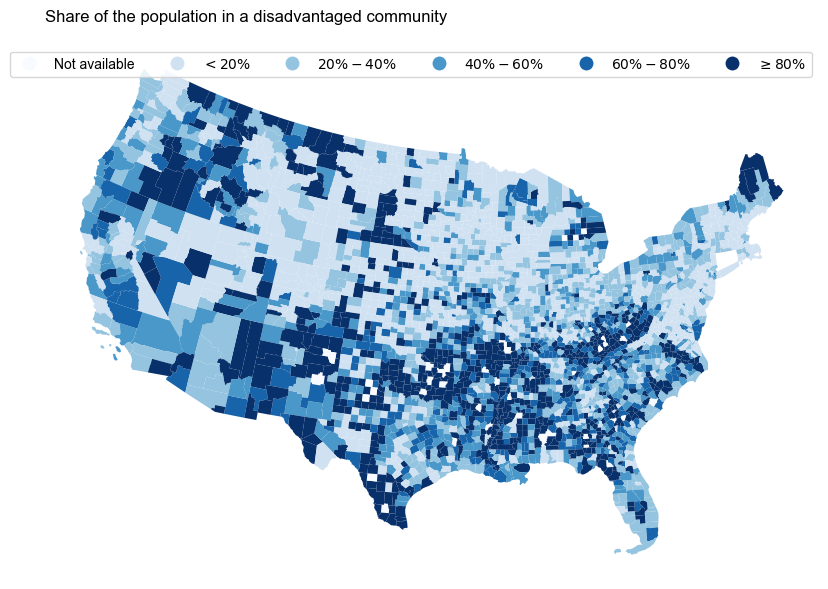

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))

lns = gdf_county.plot(column='share_IRA_binned', ax=axs, categorical=True, cmap='Blues', 
                      missing_kwds={'color': 'lightgrey'}, legend=True, legend_kwds={'ncol':6})
axs.set_title('Share of the population in a disadvantaged community', loc='left', fontsize=12)
axs.set_axis_off()

clusdict={1: '$< 20\%$', 2: '$20\% - 40\%$', 3: '$40\% - 60\%$', 4: '$60\% - 80\%$', 5: '$\geq 80\%$', 
          np.nan: 'Not available', 'NaN': 'Not available', '0':'Not available'}
relabeling = {str(i):j for i, j in clusdict.items()}

legend = axs.get_legend()
for text in legend.get_texts():
    text.set_text(relabeling[text.get_text()])
legend.set_ncols(2)   

plt.tight_layout()
plt.savefig('Figures/figureS18_map_ira_'+savedate+'.png', bbox_inches='tight', dpi=1000)
plt.show()